# ROBin's presence model

To train a model to classify the presence of trash in a bin tray. Only when trash is present, then ROBin proceeds to classify the material and type of trash.

### Update

This model is **abandoned** and the team decided to use rule based detection with OpenCV for trash presence detection,

In [31]:
from pathlib import Path
from google.colab import drive
import os
from shutil import copyfile
from zipfile import ZipFile

In [ ]:
TRAIN_DIR = "data/train"

for dir_path in [TRAIN_DIR]:
  Path(dir_path).mkdir(parents=True)

In [ ]:
def fetch_from_gdrive(dataset_download_path):
  drive.mount('drive')

  for zip, gdrive_path in dataset_download_path:
    if not os.path.exists(zip):
      print("Copying", zip)
      copyfile(src=gdrive_path, dst=zip)
    else: 
      print(zip, "already exists")
  
  drive.flush_and_unmount()


In [ ]:
PRESENCE_DATASET_ZIP = "presence_dataset_v1.zip"
PATH_TO_DATASET_ZIP = f'/content/drive/My Drive/Colab Notebooks/ROBin/datasets/{PRESENCE_DATASET_ZIP}'

fetch_from_gdrive([(PRESENCE_DATASET_ZIP, PATH_TO_DATASET_ZIP)])

for zip_path, dest_dir in [(PRESENCE_DATASET_ZIP, TRAIN_DIR)]:
  ZipFile(zip_path).extractall(dest_dir)

os.remove(PRESENCE_DATASET_ZIP)

In [35]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras import optimizers, losses, metrics
from tensorflow.keras.layers.experimental import preprocessing


class RobinPresence:
    def __init__(self, image_shape):
        self.base_model = self._construct_model(image_shape)

    def __call__(self):
        return self.base_model

    def _construct_model(self, target_size):
        preprocess_layers = [
            preprocessing.Rescaling(scale=1 / 255)
            # preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3))
        ]
        model = Sequential([
            *preprocess_layers,
            Conv2D(16, (3, 3), activation='relu'),
            MaxPool2D(2, 2),
            Conv2D(32, (3, 3), activation='relu'),
            MaxPool2D(2, 2),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPool2D(2, 2),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPool2D(2, 2),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPool2D(2, 2),
            Flatten(),
            Dense(512, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss='binary_crossentropy', metrics = ['accuracy'])
        return model

In [51]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

data_gen = ImageDataGenerator(
    vertical_flip=True,
    horizontal_flip=False,
    brightness_range=(0.5, 1.5),
    zoom_range=[0.8, 1.0],
    validation_split=0.1
  )

train_ds_gen = data_gen.flow_from_directory(
      directory='/content/data/train',
      color_mode='grayscale',
      batch_size=32,
      class_mode='binary',
      target_size=(160, 160),
      subset='training'
    )
  
valid_ds_gen = data_gen.flow_from_directory(
      directory='/content/data/train',
      color_mode='grayscale',
      batch_size=16,
      class_mode='binary',
      target_size=(160, 160),
      subset='validation'
    )
  
classnames = train_ds_gen.class_indices; print(classnames)

Found 176 images belonging to 2 classes.
Found 19 images belonging to 2 classes.
{'present': 0, 'void': 1}


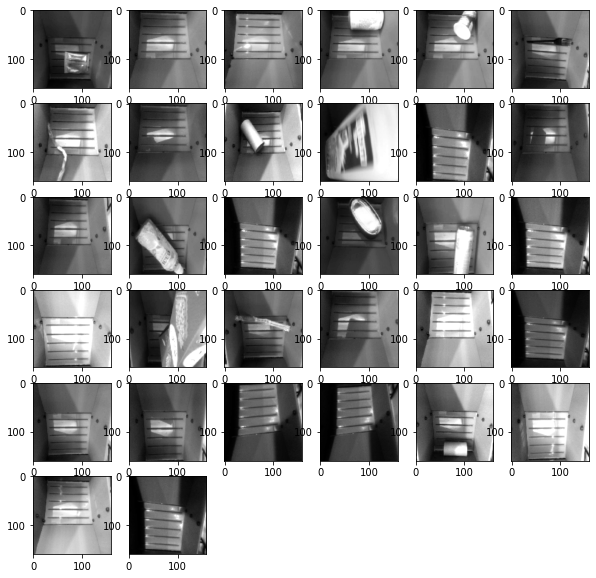

In [54]:
fig= plt.figure(figsize=(10,10))
samples = next(train_ds_gen)

i = 0
for images in samples:
  for img in (images):
    if img.ndim:
      i +=1
      foo = np.squeeze(img, axis=2)
      fig.add_subplot(6, 6, i)
      plt.imshow(foo, cmap='gray')
plt.show()

In [59]:
model = RobinPresence(image_shape=(160,160))

history = model().fit(
  x=train_ds_gen,
  validation_data=valid_ds_gen,
  epochs=80
)

Epoch 1/80
6/6 [==============================] - 1s 250ms/step - loss: 0.6918 - accuracy: 0.5057 - val_loss: 0.6971 - val_accuracy: 0.5263
Epoch 2/80
6/6 [==============================] - 1s 221ms/step - loss: 0.6863 - accuracy: 0.5227 - val_loss: 0.6910 - val_accuracy: 0.5263
Epoch 3/80
6/6 [==============================] - 1s 221ms/step - loss: 0.6792 - accuracy: 0.5455 - val_loss: 0.6973 - val_accuracy: 0.5263
Epoch 4/80
6/6 [==============================] - 1s 230ms/step - loss: 0.6815 - accuracy: 0.5114 - val_loss: 0.6865 - val_accuracy: 0.5263
Epoch 5/80
6/6 [==============================] - 1s 217ms/step - loss: 0.6677 - accuracy: 0.6761 - val_loss: 0.6907 - val_accuracy: 0.5263
Epoch 6/80
6/6 [==============================] - 1s 221ms/step - loss: 0.6652 - accuracy: 0.6420 - val_loss: 0.6768 - val_accuracy: 0.5263
Epoch 7/80
6/6 [==============================] - 1s 223ms/step - loss: 0.6482 - accuracy: 0.7216 - val_loss: 0.6708 - val_accuracy: 0.4737
Epoch 8/80
6/6 [====

Text(0.5, 1.0, 'Training and validation loss')

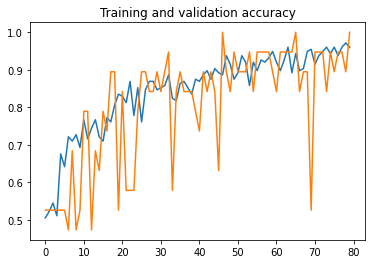

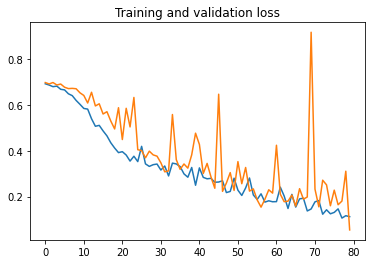

In [61]:
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [62]:
tf.saved_model.save(model(), 'output/model')

INFO:tensorflow:Assets written to: output/model/assets


INFO:tensorflow:Assets written to: output/model/assets


## Convert to TFLite

In [63]:
from tensorflow import lite
print(lite.TFLiteConverter)
def serve_tflite(saved_model_path, tflite_name, save_to):
  print("Converting saved model at", saved_model_path)
  converter = lite.TFLiteConverter.from_saved_model(saved_model_path) # path to the SavedModel directory
  tflite_model = converter.convert()
  
  save_tflite_to = f'{save_to}/{tflite_name}.tflite'
  print("Saving as", saved_model_path)
  with open(save_tflite_to, 'wb') as f:
    f.write(tflite_model)

<class 'tensorflow.lite.python.lite.TFLiteConverterV2'>


In [66]:
serve_tflite(
    saved_model_path="/content/output/model",
    tflite_name="robin_presence_v1.1",
    save_to="/content/output/lite"
)

Converting saved model at /content/output/model
Saving as /content/output/model


In [67]:
%%bash

cd output
zip -r /content/robin_presence_v1.1.zip .

  adding: lite/ (stored 0%)
  adding: lite/.ipynb_checkpoints/ (stored 0%)
  adding: lite/robin_presence_v1.1.tflite (deflated 8%)
  adding: .ipynb_checkpoints/ (stored 0%)
  adding: model/ (stored 0%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: model/variables/variables.index (deflated 69%)
  adding: model/saved_model.pb (deflated 90%)
  adding: model/assets/ (stored 0%)
